<a href="https://colab.research.google.com/github/junohjung/ai-science-training-series/blob/main/2024_11_16_JungHomework_Session2.ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Neural Networks
Author: Marieme Ngom, adapting materials from Bethany Lusch, Asad Khan, Prasanna Balaprakash, Taylor Childers, Corey Adams, Kyle Felker, and Tanwi Mallick.

This tutorial will serve as a gentle introduction to neural networks and deep learning through a hands-on classification problem using the MNIST dataset.

In particular, we will introduce neural networks and how to train and improve their learning capabilities.  We will use the PyTorch Python library.

The [MNIST dataset](http://yann.lecun.com/exdb/mnist/) contains thousands of examples of handwritten numbers, with each digit labeled 0-9.
<img src="https://github.com/junohjung/ai-science-training-series/blob/main/02_intro_neural_networks/images/mnist_task.png?raw=1"  align="left"/>



In [ ]:
%matplotlib inline

import torch
import torchvision
from torch import nn

import numpy
import matplotlib.pyplot as plt
import time

## The MNIST dataset

We will now download the dataset that contains handwritten digits. MNIST is a popular dataset, so we can download it via the PyTorch library. Note:
- x is for the inputs (images of handwritten digits) and y is for the labels or outputs (digits 0-9)
- We are given "training" and "test" datasets. Training datasets are used to fit the model. Test datasets are saved until the end, when we are satisfied with our model, to estimate how well our model generalizes to new data.

Note that downloading it the first time might take some time.
The data is split as follows:
- 60,000 training examples, 10,000 test examples
- inputs: 1 x 28 x 28 pixels
- outputs (labels): one integer per example

In [ ]:
training_data = torchvision.datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

test_data = torchvision.datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 37.0MB/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.17MB/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 9.81MB/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 1.55MB/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
train_size = int(0.8 * len(training_data))  # 80% for training
val_size = len(training_data) - train_size  # Remaining 20% for validation
training_data, validation_data = torch.utils.data.random_split(training_data, [train_size, val_size], generator=torch.Generator().manual_seed(55))

In [ ]:
print('MNIST data loaded: train:',len(training_data),' examples, validation: ', len(validation_data), 'examples, test:',len(test_data), 'examples')
print('Input shape', training_data[0][0].shape)

MNIST data loaded: train: 48000  examples, validation:  12000 examples, test: 10000 examples
Input shape torch.Size([1, 28, 28])


Let's take a closer look. Here are the first 10 training digits:

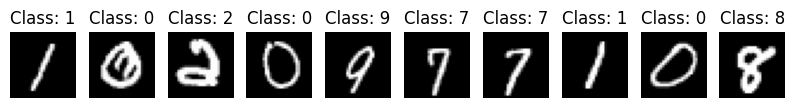

In [ ]:
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(numpy.reshape(training_data[i][0], (28, 28)), cmap="gray")
    plt.title('Class: '+str(training_data[i][1]))

# Generalities:
To train our classifier, we need (besides the data):
- A model that depend on parameters $\mathbf{\theta}$. Here we are going to use neural networks.
- A loss function $J(\mathbf{\theta})$ to measure the capabilities of the model.
- An optimization method.

# Linear Model
Let's begin with a simple linear model: linear regression, like last week.
We add one complication: each example is a vector (flattened image), so the "slope" multiplication becomes a dot product. If the target output is a vector as well, then the multiplication becomes matrix multiplication.

Note, like before, we consider multiple examples at once, adding another dimension to the input.


 <img src="https://github.com/junohjung/ai-science-training-series/blob/main/02_intro_neural_networks/images/LinearModel_1.png?raw=1"  align="center"/>



The linear layers in PyTorch perform a basic $xW + b$. These "fully connected" layers connect each input to each output with some weight parameter. We wouldn't expect a simple linear model $f(x) = xW+b$ directly outputting the class label and minimizing mean squared error to work well - the model would output labels like 3.55 and 2.11 instead of skipping to integers.

We now need:
- A loss function $J(\theta)$ where $\theta$ is the list of parameters (here W and b). Last week, we used mean squared error (MSE), but this week let's make two changes that make more sense for classification:
    - Change the output to be a length-10 vector of class probabilities (0 to 1, adding to 1).
    - Cross entropy as the loss function, which is typical for classification. You can read more [here](https://gombru.github.io/2018/05/23/cross_entropy_loss/).

- An optimization method or optimizer such as the stochastic gradient descent (sgd) method, the Adam optimizer, RMSprop, Adagrad etc. Let's start with stochastic gradient descent (sgd), like last week. For far more information about more advanced optimizers than basic SGD, with some cool animations, see https://ruder.io/optimizing-gradient-descent/ or https://distill.pub/2017/momentum/.

- A learning rate. As we learned last week, the learning rate controls how far we move during each step.

In [ ]:
class LinearClassifier(nn.Module):

    def __init__(self):
        super().__init__()

        # First, we need to convert the input image to a vector by using
        # nn.Flatten(). For MNIST, it means the second dimension 28*28 becomes 784.
        self.flatten = nn.Flatten()

        # Here, we add a fully connected ("dense") layer that has 28 x 28 = 784 input nodes
        #(one for each pixel in the input image) and 10 output nodes (for probabilities of each class).
        self.layer_1 = nn.Linear(28*28, 10)

    def forward(self, x):

        x = self.flatten(x)
        x = self.layer_1(x)

        return x

In [ ]:
linear_model = LinearClassifier()
print(linear_model)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(linear_model.parameters(), lr=0.3)

LinearClassifier(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layer_1): Linear(in_features=784, out_features=10, bias=True)
)


# Learning
Now we are ready to train our first model. A training step is comprised of:
- A forward pass: the input is passed through the network
- Backpropagation: A backward pass to compute the gradient $\frac{\partial J}{\partial \mathbf{W}}$ of the loss function with respect to the parameters of the network.
- Weight updates $\mathbf{W} = \mathbf{W} - \alpha \frac{\partial J}{\partial \mathbf{W}} $ where $\alpha$ is the learning rate.

How many steps do we take?
- The batch size corresponds to the number of training examples in one pass (forward + backward). A smaller batch size allows the model to learn from individual examples but takes longer to train. A larger batch size requires fewer steps but may result in the model not capturing the nuances in the data. The higher the batch size, the more memory you will require.  
- An epoch means one pass through the whole training data (looping over the batches). Using few epochs can lead to underfitting and using too many can lead to overfitting.
- The choice of batch size and learning rate are important for performance, generalization and accuracy in deep learning.






In [ ]:
batch_size = 128

# The dataloader makes our dataset iterable
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)

In [ ]:
def train_one_epoch(dataloader, model, loss_fn, optimizer):
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # forward pass
        pred = model(X)
        loss = loss_fn(pred, y)

        # backward pass calculates gradients
        loss.backward()

        # take one step with these gradients
        optimizer.step()

        # resets the gradients
        optimizer.zero_grad()

In [ ]:
def evaluate(dataloader, model, loss_fn):
    # Set the model to evaluation mode - some NN pieces behave differently during training
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    loss, correct = 0, 0

    # We can save computation and memory by not calculating gradients here - we aren't optimizing
    with torch.no_grad():
        # loop over all of the batches
        for X, y in dataloader:
            pred = model(X)
            loss += loss_fn(pred, y).item()
            # how many are correct in this batch? Tracking for accuracy
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    loss /= num_batches
    correct /= size

    accuracy = 100*correct
    return accuracy, loss

In [ ]:
%%time

epochs = 5
train_acc_all = []
val_acc_all = []
for j in range(epochs):
    train_one_epoch(train_dataloader, linear_model, loss_fn, optimizer)

    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, linear_model, loss_fn)
    train_acc_all.append(acc)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

    # checking on the validation loss and accuracy once per epoch
    val_acc, val_loss = evaluate(val_dataloader, linear_model, loss_fn)
    val_acc_all.append(val_acc)
    print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

Epoch 0: training loss: 0.3509347072839737, accuracy: 90.4375
Epoch 0: val. loss: 0.33946207609582457, val. accuracy: 90.4
Epoch 1: training loss: 0.32003514417012535, accuracy: 91.2
Epoch 1: val. loss: 0.309856190326366, val. accuracy: 91.21666666666667
Epoch 2: training loss: 0.3057108025550842, accuracy: 91.61041666666667
Epoch 2: val. loss: 0.2970297376209117, val. accuracy: 91.58333333333334
Epoch 3: training loss: 0.2968129822810491, accuracy: 91.84375
Epoch 3: val. loss: 0.2895718773311757, val. accuracy: 91.81666666666666
Epoch 4: training loss: 0.2905036486585935, accuracy: 92.0125
Epoch 4: val. loss: 0.28462145192191957, val. accuracy: 91.93333333333334
CPU times: user 1min 15s, sys: 340 ms, total: 1min 16s
Wall time: 1min 26s


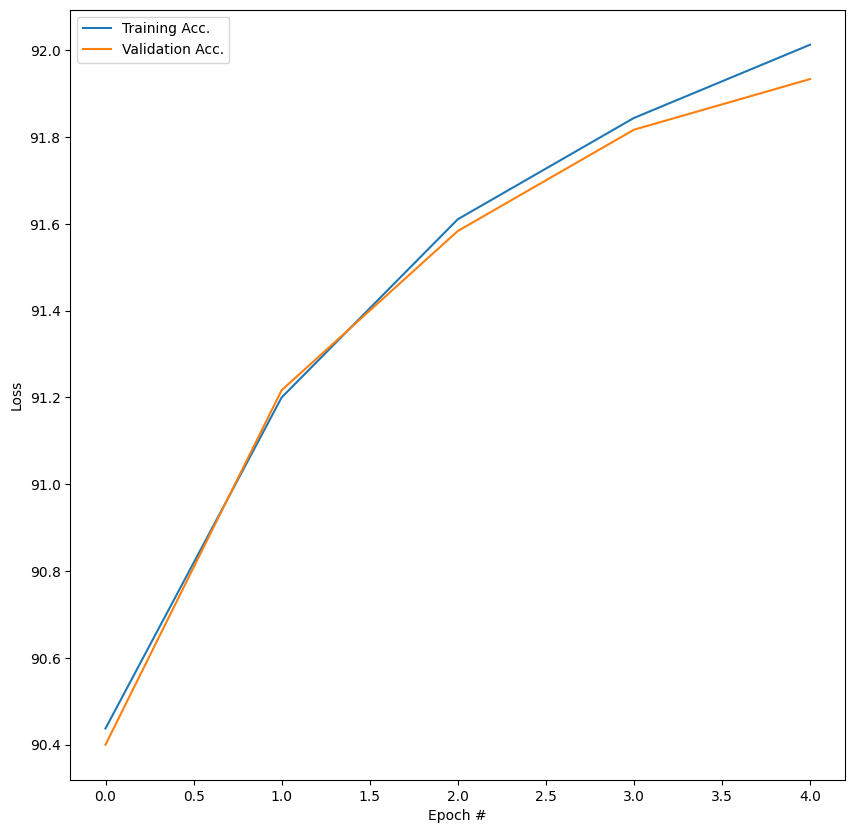

In [ ]:
pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_acc_all,label = 'Training Acc.' )
plt.plot(range(epochs), val_acc_all, label = 'Validation Acc.' )
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

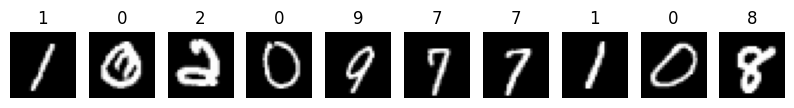

In [ ]:
# Visualize how the model is doing on the first 10 examples
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))
linear_model.eval()
batch = next(iter(train_dataloader))
predictions = linear_model(batch[0])

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(batch[0][i,0,:,:], cmap="gray")
    plt.title('%d' % predictions[i,:].argmax())

Exercise: How can you improve the accuracy? Some things you might consider: increasing the number of epochs, changing the learning rate, etc.

# Prediction

Let's see how our model generalizes to the unseen test data.



In [ ]:
#create dataloader for test data
# The dataloader makes our dataset iterable
batch_size_test = 128
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size_test)

In [ ]:
acc_test, loss_test = evaluate(test_dataloader, linear_model, loss_fn)
print("Test loss: %.4f, test accuracy: %.2f%%" % (loss_test, acc_test))

Test loss: 0.2850, test accuracy: 92.11%


We can now take a closer look at the results.

Let's define a helper function to show the failure cases of our classifier.

In [ ]:
def show_failures(model, dataloader, maxtoshow=10):
    model.eval()
    batch = next(iter(dataloader))
    predictions = model(batch[0])

    rounded = predictions.argmax(1)
    errors = rounded!=batch[1]
    print('Showing max', maxtoshow, 'first failures. '
          'The predicted class is shown first and the correct class in parentheses.')
    ii = 0
    plt.figure(figsize=(maxtoshow, 1))
    for i in range(batch[0].shape[0]):
        if ii>=maxtoshow:
            break
        if errors[i]:
            plt.subplot(1, maxtoshow, ii+1)
            plt.axis('off')
            plt.imshow(batch[0][i,0,:,:], cmap="gray")
            plt.title("%d (%d)" % (rounded[i], batch[1][i]))
            ii = ii + 1

Here are the first 10 images from the test data that this small model classified to a wrong class:



Showing max 10 first failures. The predicted class is shown first and the correct class in parentheses.


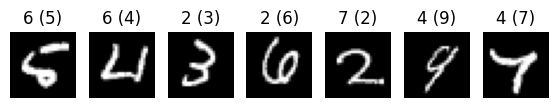

In [ ]:
show_failures(linear_model, test_dataloader)

<!-- # Exercise:
- Try changing the loss function,
- Try changing the optimizer -->

# Multilayer Model
Our linear model isn't enough for high accuracy on this dataset. To improve the model, we often need to add more layers and nonlinearities.
<img src="https://github.com/junohjung/ai-science-training-series/blob/main/02_intro_neural_networks/images/shallow_nn.png?raw=1"  align="left"/>

The output of this NN can be written as
\begin{equation}\label{eq: NN1d}
  \hat{u}(x) = \sigma_2(\sigma_1(\mathbf{x}\mathbf{W}_1 + \mathbf{b}_1)\mathbf{W}_2 + \mathbf{b}_2),
\end{equation}
where $\mathbf{x}$ is the input, $\mathbf{W}_j$ are the weights of the neural network, $\sigma_j$ the (nonlinear) activation functions, and $\mathbf{b}_j$ its biases. The activation function introduces the nonlinearity and makes it possible to learn more complex tasks. Desirable properties in an activation function include being differentiable, bounded, and monotonic.


Image source: [PragatiBaheti](https://www.v7labs.com/blog/neural-networks-activation-functions)
<img src="https://github.com/junohjung/ai-science-training-series/blob/main/02_intro_neural_networks/images/activation.jpeg?raw=1"  align="center"/>

Adding more layers to obtain a deep neural network:
<img src="https://github.com/junohjung/ai-science-training-series/blob/main/02_intro_neural_networks/images/deep_nn_annotated.jpg?raw=1"  align="left"/>



# Important things to know
Deep Neural networks can be overly flexible/complicated and "overfit" your data, just like fitting overly complicated polynomials:
<img src="https://github.com/junohjung/ai-science-training-series/blob/main/02_intro_neural_networks/images/bias_vs_variance.png?raw=1"  align="left"/>


Vizualization wrt to the accuracy and loss (Image source: [Baeldung](https://www.baeldung.com/cs/ml-underfitting-overfitting)):
<img src="https://github.com/junohjung/ai-science-training-series/blob/main/02_intro_neural_networks/images/acc_under_over.webp?raw=1"  align="center"/>


To improve the generalization of our model on previously unseen data, we employ a technique known as regularization, which constrains our optimization problem in order to discourage complex models.

  - Dropout is the commonly used regularization technique. The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting.
  - Penalizing the loss function by adding a term such as $\lambda ||\mathbf{W}||^2$ is alsp a commonly used regularization technique. This helps "control" the magnitude of the weights of the network.
    
Vanishing gradients: Gradients become small as they propagate backward through the layers. Squashing activation functions like sigmoid or tanh could cause this.

Exploding gradients: Gradients grow exponentially usually due to "poor" weight initialization.

<!--  <img src="images/test_data_rule.png" width="800" hight="500" align="center"/>
  -->

We can now implement a deep network in PyTorch. nn.Dropout() performs the Dropout operation mentioned earlier

In [ ]:
class NonlinearClassifier(nn.Module):

    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(28*28, 50),
            nn.Sigmoid(), #nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.Tanh(), #nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Dropout(0.2),
           # nn.Linear(50, 10)
        )
            #nn.Linear(28*28, 50),
            #nn.ReLU(),
            #nn.Dropout(0.2),
            #nn.Linear(50, 50),
            #nn.ReLU(),
            #nn.Dropout(0.2),
            #nn.Linear(50, 50),
            #nn.ReLU(),
            #nn.Dropout(0.2),
            #nn.Linear(50, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.layers_stack(x)

        return x

In [ ]:
nonlinear_model = NonlinearClassifier()
print(nonlinear_model)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=0.3)
print(nonlinear_model.parameters())

NonlinearClassifier(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layers_stack): Sequential(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): Sigmoid()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Tanh()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=50, out_features=50, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
  )
)
<generator object Module.parameters at 0x7fa21d74bdf0>


In [ ]:
%%time

epochs = 10
train_acc_all = []
val_acc_all = []
for j in range(epochs):
    train_one_epoch(train_dataloader, nonlinear_model, loss_fn, optimizer)

    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, nonlinear_model, loss_fn)
    train_acc_all.append(acc)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

    # checking on the validation loss and accuracy once per epoch
    val_acc, val_loss = evaluate(val_dataloader, nonlinear_model, loss_fn)
    val_acc_all.append(val_acc)
    print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

Epoch 0: training loss: 0.6564204364617665, accuracy: 88.37708333333333
Epoch 0: val. loss: 0.6491509530138462, val. accuracy: 88.34166666666667


KeyboardInterrupt: 

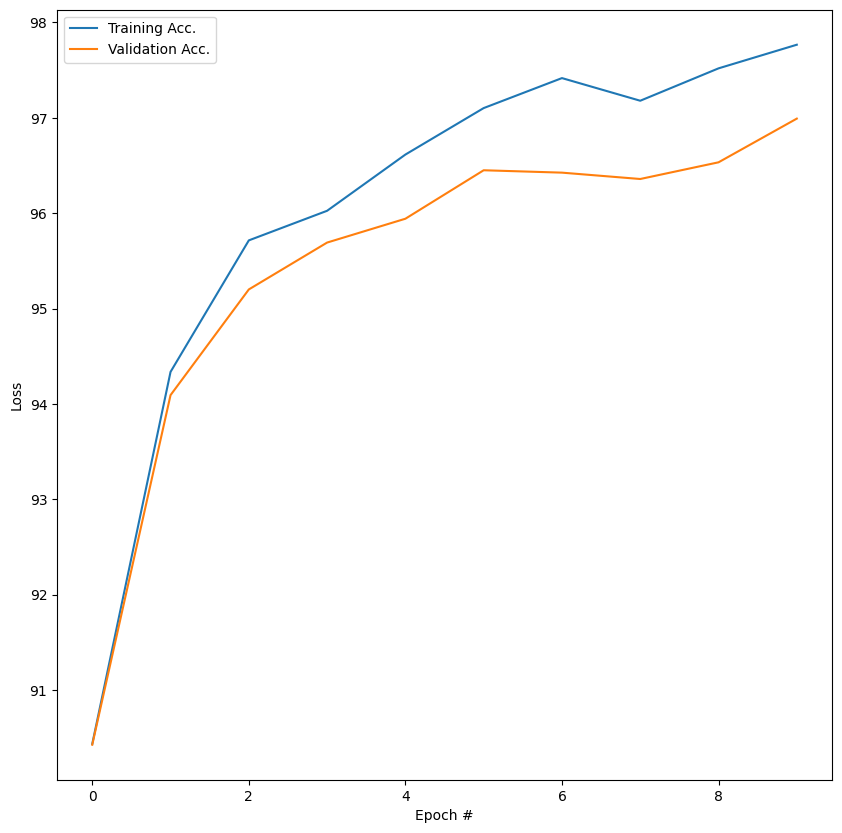

In [ ]:
pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_acc_all,label = 'Training Acc.' )
plt.plot(range(epochs), val_acc_all, label = 'Validation Acc.' )
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

Showing max 10 first failures. The predicted class is shown first and the correct class in parentheses.


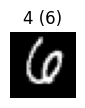

In [ ]:
show_failures(nonlinear_model, test_dataloader)

# Recap
To train and validate a neural network model, you need:
- Data split into training/validation/test sets,
- A model with parameters to learn,
- An appropriate loss function,
- An optimizer (with tunable parameters such as learning rate, weight decay etc.) used to learn the parameters of the model.


# Homework

1. Compare the quality of your model when using different:
 - batch sizes,
 - learning rates,
 - activation functions.

3. Bonus: What is a learning rate scheduler?

If you have time, experiment with how to improve the model. Note: training and validation data can be used to compare models, but test data should be saved until the end as a final check of generalization.

Case 1) changing a batch size:

A larger batch size tends to decrease the accuracy of both training and validation. However, increasing the number of epochs can lead to further improvements in accuracy.

Batch size:32

Epoch 0: training loss: 0.29131900386884807, accuracy: 91.525

Epoch 0: val. loss: 0.2841597080429395, val. accuracy: 91.45833333333333

Epoch 1: training loss: 0.18409809742371241, accuracy: 94.53958333333333

Epoch 1: val. loss: 0.19084752556681633, val. accuracy: 94.25

Epoch 2: training loss: 0.15294542299055805, accuracy: 95.40625

Epoch 2: val. loss: 0.165590115668873, val. accuracy: 95.00833333333333

Epoch 3: training loss: 0.11862136484667038, accuracy: 96.45625

Epoch 3: val. loss: 0.13705157951141397, val. accuracy: 95.80833333333332

Epoch 4: training loss: 0.11588265312532894, accuracy: 96.50416666666666

Epoch 4: val. loss: 0.13722581070226927, val. accuracy: 95.96666666666667

CPU times: user 1min 43s, sys: 256 ms, total: 1min 44s

Wall time: 1min 44s

Batch size:64

Epoch 0: training loss: 0.6258238563537598, accuracy: 83.275

Epoch 0: val. loss: 0.6197105801485955, val. accuracy: 82.875

Epoch 1: training loss: 0.36681868465741474, accuracy: 89.58333333333334

Epoch 1: val. loss: 0.3580862220297468, val. accuracy: 89.59166666666667

Epoch 2: training loss: 0.27679769706726076, accuracy: 92.09166666666667

Epoch 2: val. loss: 0.27044944179818986, val. accuracy: 91.975

Epoch 3: training loss: 0.23461232008536656, accuracy: 93.18333333333332

Epoch 3: val. loss: 0.23229535090479445, val. accuracy: 92.99166666666666

Epoch 4: training loss: 0.20071764115492502, accuracy: 94.2125

Epoch 4: val. loss: 0.20180098030795443, val. accuracy: 93.94166666666666

CPU times: user 1min 20s, sys: 230 ms, total: 1min 20s

Wall time: 1min 22s




Batch size:128

Epoch 0: training loss: 0.9381435205141704, accuracy: 73.70416666666667

Epoch 0: val. loss: 0.9299069040633262, val. accuracy: 73.58333333333333

Epoch 1: training loss: 0.4153559052149455, accuracy: 88.43958333333333

Epoch 1: val. loss: 0.40775066360514217, val. accuracy: 88.5

Epoch 2: training loss: 0.3237801838318507, accuracy: 90.85

Epoch 2: val. loss: 0.3187925840945954, val. accuracy: 90.65833333333333

Epoch 3: training loss: 0.263333734691143, accuracy: 92.44791666666666

Epoch 3: val. loss: 0.2617023230550137, val. accuracy: 92.4

Epoch 4: training loss: 0.22751247133811314, accuracy: 93.38333333333333

Epoch 4: val. loss: 0.22953893664352437, val. accuracy: 93.18333333333332

CPU times: user 1min 22s, sys: 234 ms, total: 1min 23s

Wall time: 1min 24s


Batch size: 256

Epoch 0: training loss: 0.6883666985829672, accuracy: 80.14375

Epoch 0: val. loss: 0.6844882083700058, val. accuracy: 79.65

Epoch 1: training loss: 0.3818241737683614, accuracy: 88.89166666666667

Epoch 1: val. loss: 0.3753638118505478, val. accuracy: 89.05

Epoch 2: training loss: 0.297781964023908, accuracy: 91.41458333333333

Epoch 2: val. loss: 0.29112379474842803, val. accuracy: 91.60000000000001

Epoch 3: training loss: 0.24593730445702872, accuracy: 92.875

Epoch 3: val. loss: 0.2453317843536113, val. accuracy: 92.70833333333334

Epoch 4: training loss: 0.2089225091934204, accuracy: 93.875

Epoch 4: val. loss: 0.2114112250348355, val. accuracy: 93.65

CPU times: user 1min 23s, sys: 216 ms, total: 1min 24s

Wall time: 1min 24s

Case 2) changing learning rate

Increasing learning rate when the batch size is 128

**case 1: lr=0.05**

Epoch 0: training loss: 0.7054495368003845, accuracy: 80.58125000000001

Epoch 0: val. loss: 0.6976430504880053, val. accuracy: 80.23333333333333

Epoch 1: training loss: 0.39384935518105824, accuracy: 88.91666666666667

Epoch 1: val. loss: 0.38333532753142907, val. accuracy: 89.03333333333333

Epoch 2: training loss: 0.3168396691083908, accuracy: 90.99791666666667

Epoch 2: val. loss: 0.30668793824758933, val. accuracy: 90.95

Epoch 3: training loss: 0.26911213290691377, accuracy: 92.16666666666666

Epoch 3: val. loss: 0.26385345492274204, val. accuracy: 91.98333333333333

Epoch 4: training loss: 0.23557254030307134, accuracy: 93.06458333333333

Epoch 4: val. loss: 0.23513868673050659, val. accuracy: 92.81666666666666

Epoch 5: training loss: 0.19646135606368384, accuracy: 94.27083333333334

Epoch 5: val. loss: 0.19845211062025517, val. accuracy: 94.08333333333333

Epoch 6: training loss: 0.17811596061786017, accuracy: 94.77083333333334

Epoch 6: val. loss: 0.18287449876995795, val. accuracy: 94.43333333333334

Epoch 7: training loss: 0.15860307662685713, accuracy: 95.4125

Epoch 7: val. loss: 0.16560463171373022, val. accuracy: 94.95

Epoch 8: training loss: 0.1470012096464634, accuracy: 95.73958333333333

Epoch 8: val. loss: 0.15763748084452558, val. accuracy: 95.35833333333333

Epoch 9: training loss: 0.13281818852821986, accuracy: 96.11041666666667

Epoch 9: val. loss: 0.14512682603077687, val. accuracy: 95.75

CPU times: user 2min 51s, sys: 436 ms, total: 2min 51s

Wall time: 2min 54s

**case 2: lr=0.1**

Epoch 0: training loss: 0.42249138867855074, accuracy: 87.9375

Epoch 0: val. loss: 0.4182213820675586, val. accuracy: 87.59166666666667

Epoch 1: training loss: 0.27233588713407514, accuracy: 92.06458333333333

Epoch 1: val. loss: 0.26649454331144373, val. accuracy: 91.78333333333333

Epoch 2: training loss: 0.20216313660144805, accuracy: 94.07708333333333

Epoch 2: val. loss: 0.19866923266585837, val. accuracy: 93.83333333333333

Epoch 3: training loss: 0.162623608648777, accuracy: 95.18958333333333

Epoch 3: val. loss: 0.16473303037755033, val. accuracy: 95.0

Epoch 4: training loss: 0.1449021589756012, accuracy: 95.74166666666667

Epoch 4: val. loss: 0.15292797499197594, val. accuracy: 95.375

Epoch 5: training loss: 0.12268872735400994, accuracy: 96.42291666666667

Epoch 5: val. loss: 0.13631316698453527, val. accuracy: 95.92500000000001

Epoch 6: training loss: 0.10751236519217491, accuracy: 96.8625

Epoch 6: val. loss: 0.1251274994079103, val. accuracy: 96.23333333333333

Epoch 7: training loss: 0.10149870605270069, accuracy: 97.02083333333333

Epoch 7: val. loss: 0.12504381165304718, val. accuracy: 96.26666666666667

Epoch 8: training loss: 0.10177444050709407, accuracy: 96.95625

Epoch 8: val. loss: 0.12256500899712457, val. accuracy: 96.29166666666666

Epoch 9: training loss: 0.08529789289583763, accuracy: 97.48541666666667

Epoch 9: val. loss: 0.1121811194820924, val. accuracy: 96.48333333333333

CPU times: user 2min 45s, sys: 471 ms, total: 2min 46s

Wall time: 2min 47s


**case 3: lr=0.2**

Epoch 0: training loss: 0.30787422092755634, accuracy: 90.43333333333334

Epoch 0: val. loss: 0.30312057394296565, val. accuracy: 90.425

Epoch 1: training loss: 0.1899070992867152, accuracy: 94.33541666666667

Epoch 1: val. loss: 0.19753529725873725, val. accuracy: 94.09166666666667

Epoch 2: training loss: 0.1416174286107222, accuracy: 95.71458333333334

Epoch 2: val. loss: 0.15497982391017548, val. accuracy: 95.19999999999999

Epoch 3: training loss: 0.13038782139619193, accuracy: 96.025

Epoch 3: val. loss: 0.146780738448526, val. accuracy: 95.69166666666666

Epoch 4: training loss: 0.10988345964252949, accuracy: 96.61458333333334

Epoch 4: val. loss: 0.13384335995354552, val. accuracy: 95.94166666666666

Epoch 5: training loss: 0.09641316247483095, accuracy: 97.10208333333334

Epoch 5: val. loss: 0.11951003469368245, val. accuracy: 96.45

Epoch 6: training loss: 0.0851337542682886, accuracy: 97.41666666666666

Epoch 6: val. loss: 0.11780832155032996, val. accuracy: 96.42500000000001

Epoch 7: training loss: 0.09208646741012733, accuracy: 97.17916666666667

Epoch 7: val. loss: 0.12309837676188413, val. accuracy: 96.35833333333333

Epoch 8: training loss: 0.08219975915799538, accuracy: 97.51875

Epoch 8: val. loss: 0.11629172390762796, val. accuracy: 96.53333333333333

Epoch 9: training loss: 0.07177605073153973, accuracy: 97.76666666666667

Epoch 9: val. loss: 0.10600652860754982, val. accuracy: 96.99166666666666

CPU times: user 2min 46s, sys: 445 ms, total: 2min 47s

Wall time: 2min 49s


Case 3) changing actication functions

Linear model vs nonlinear models

Based on the workshop session, we learned that when the data is complex, it is encounraged to use nonlinear models.



            batch size =128, lr=0.3
            
            nn.Linear(28*28, 50),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(50, 10)

Epoch 0: training loss: 0.26729255012671155, accuracy: 92.14375

Epoch 0: val. loss: 0.2640840817005076, val. accuracy: 91.94166666666666

Epoch 1: training loss: 0.18869464746117592, accuracy: 94.47916666666667

Epoch 1: val. loss: 0.19057613413067573, val. accuracy: 94.24166666666667

Epoch 2: training loss: 0.1497707671970129, accuracy: 95.68541666666667

Epoch 2: val. loss: 0.15608188018519828, val. accuracy: 95.26666666666667

Epoch 3: training loss: 0.158395018607378, accuracy: 95.275

Epoch 3: val. loss: 0.16640863436809245, val. accuracy: 95.15833333333333

Epoch 4: training loss: 0.1172935082167387, accuracy: 96.51666666666667

Epoch 4: val. loss: 0.13357398173514198, val. accuracy: 96.04166666666667

Epoch 5: training loss: 0.10673859466115633, accuracy: 96.83958333333334

Epoch 5: val. loss: 0.12645901725726558, val. accuracy: 96.21666666666667

Epoch 6: training loss: 0.10672907103101413, accuracy: 96.73958333333333

Epoch 6: val. loss: 0.13441027039067543, val. accuracy: 96.05

Epoch 7: training loss: 0.09520059526711702, accuracy: 97.13333333333334

Epoch 7: val. loss: 0.12319129336863122, val. accuracy: 96.50833333333333

Epoch 8: training loss: 0.0915482457006971, accuracy: 97.25208333333333

Epoch 8: val. loss: 0.12184755557632827, val. accuracy: 96.51666666666667

Epoch 9: training loss: 0.08303700684756041, accuracy: 97.49166666666666

Epoch 9: val. loss: 0.11703302026627228, val. accuracy: 96.54166666666667

CPU times: user 2min 32s, sys: 337 ms, total: 2min 32s

Wall time: 2min 33s

The dropout which is for regularization works for improvement of the accuracy.

batch_size=128 lr=0.3

            nn.Linear(28*28, 50),
            nn.Sigmoid(), #nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(50, 50),


Epoch 0: training loss: 0.44581544494628905, accuracy: 88.61666666666666

Epoch 0: val. loss: 0.43788369602345406, val. accuracy: 88.66666666666667

Epoch 1: training loss: 0.33875611062844596, accuracy: 90.55625

Epoch 1: val. loss: 0.3288847815166128, val. accuracy: 90.7

Epoch 2: training loss: 0.2974626346826553, accuracy: 91.64375

Epoch 2: val. loss: 0.2877089924951817, val. accuracy: 91.59166666666667

Epoch 3: training loss: 0.270755511879921, accuracy: 92.35833333333333

Epoch 3: val. loss: 0.262733333922447, val. accuracy: 92.25

Epoch 4: training loss: 0.2507853065331777, accuracy: 92.85416666666667

Epoch 4: val. loss: 0.24446749338444243, val. accuracy: 92.76666666666667

Epoch 5: training loss: 0.23335377138853072, accuracy: 93.36041666666667

Epoch 5: val. loss: 0.2287518858434038, val. accuracy: 93.175

Epoch 6: training loss: 0.21995131558179856, accuracy: 93.68958333333333

Epoch 6: val. loss: 0.216792928332344, val. accuracy: 93.525

Epoch 7: training loss: 0.2062664137283961, accuracy: 94.15625

Epoch 7: val. loss: 0.2044300415572968, val. accuracy: 93.89166666666667

Epoch 8: training loss: 0.19641785301764805, accuracy: 94.42291666666667

Epoch 8: val. loss: 0.1958484008432703, val. accuracy: 94.18333333333334

Epoch 9: training loss: 0.18750431855519611, accuracy: 94.66458333333333

Epoch 9: val. loss: 0.1881109189955478, val. accuracy: 94.375

CPU times: user 2min 30s, sys: 336 ms, total: 2min 30s

Wall time: 2min 31s

When the layer become simple, then the accuracy become less.
Also, I noticed that if there is no linear actuation function at the last step, the accuracy is very poor. The appropriate use of the activation functions are important. How to choose needs to be investigated....